In [1]:
import re
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize']=(16,6)

In [26]:
realt = pd.read_csv('../data/realt_lite.csv', encoding='cp1251')

#### Total area

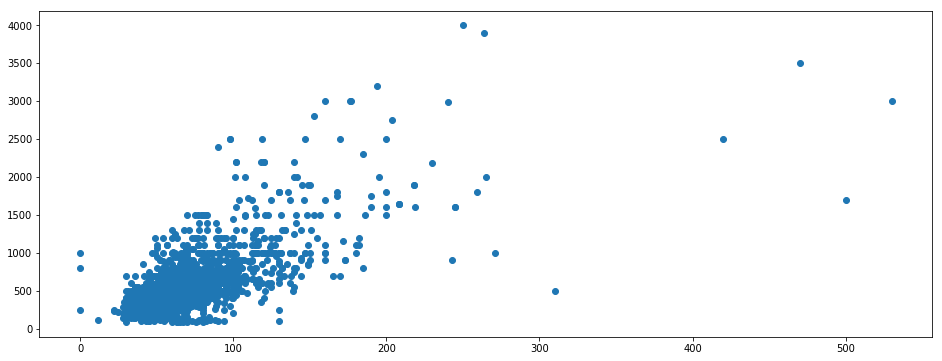

In [18]:
plt.scatter( realt['total_area'], realt['price_usa'])

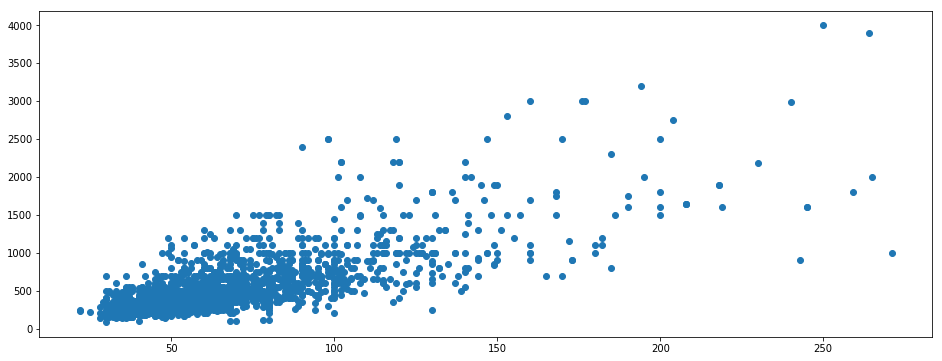

In [29]:
# Замена нулей в общей площади на медианную площадь для квартир с таким же кол-вом комнат
realt.loc[realt[(realt['total_area']==0)].index, 'total_area'] = realt[(realt['total_area']==0)].merge(
    realt.groupby(by='rooms').agg(
        [np.mean, np.min, np.max, np.median]
    )['total_area'].reset_index(),
    on='rooms'
)['median']
# Убираем обьявления по комнатам и коттеджам
flat_realt = realt[(realt['total_area']<=300) &(realt['rooms']!=0)]
plt.scatter( flat_realt['total_area'], flat_realt['price_usa'])

#### Photos

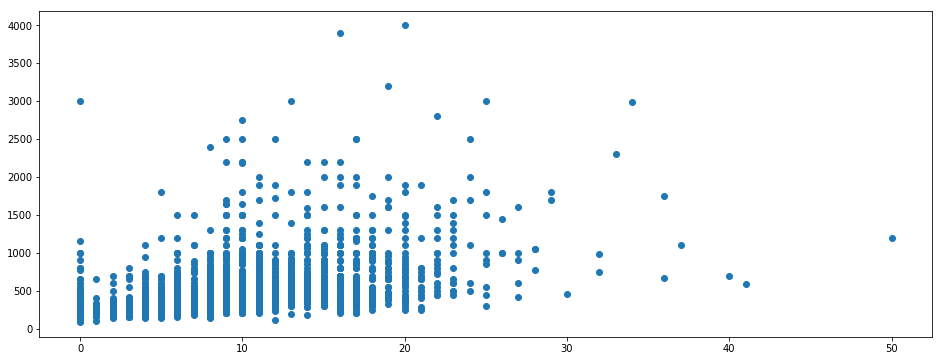

In [20]:
plt.scatter(flat_realt['photos'], flat_realt['price_usa'])

In [30]:
flat_realt['photos_proc'] = pd.concat([flat_realt['photos'] ,pd.DataFrame(25*np.ones([realt.shape[0],1]))], axis=1).min(axis=1)
# Добавление новой колонки
flat_realt['photo_exist'] = flat_realt['photos_proc'].apply(lambda x: 0 if x==0 else 1) 

C:\Users\Aleh_Darashenka\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Aleh_Darashenka\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


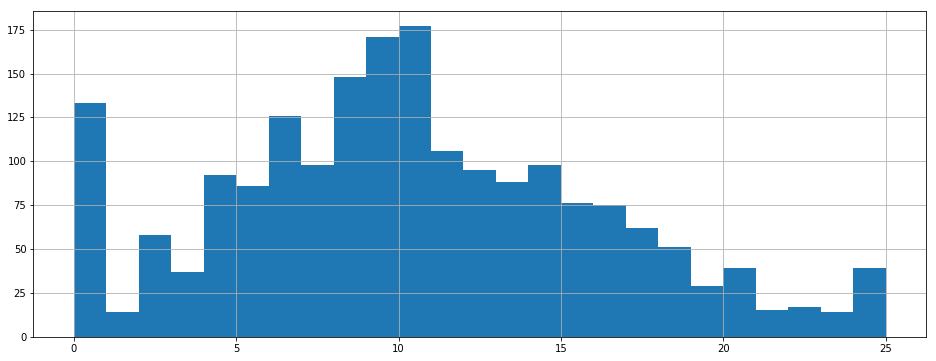

In [22]:
flat_realt['photos_proc'].hist(bins=25)

In [65]:
flat_realt.isnull().sum(axis=0)

address                  0
code                     0
description           1271
floor                    0
latitude                 0
longitude                0
photos                   0
price_local              0
price_usa                0
views_day                0
views_week               0
zones                    0
Агентство                0
Балкон                   0
Бытовая техника        761
Год постройки            0
Дата обновления          0
Дополнительно          813
Мебель                   0
Метро                    0
Планировка               0
Плита                    0
Полы                   388
Примечания            1048
Район города             0
Ремонт                   0
Сан/узел                 0
Соседи по квартире    1938
Телефон                  0
Тип дома                 0
До центра                0
До метро                 0
rooms                    0
total_area               0
living_area              0
kitchen_area             0
floors                   0
Л

#### Год постройки

In [31]:
# Если по этому же адресу есть еще обьявление с указанием года постройки, то он проставится и этому обьявлению
house_year = flat_realt[~pd.isnull(flat_realt['Год постройки'])][['address', 'Год постройки']].groupby(by='address').mean().reset_index()
house_year.set_index('address', inplace=True)
flat_realt.set_index('address', inplace=True)
flat_realt['Год постройки'] = flat_realt['Год постройки'].fillna(value=house_year['Год постройки'])
flat_realt.reset_index(inplace=True)

C:\Users\Aleh_Darashenka\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


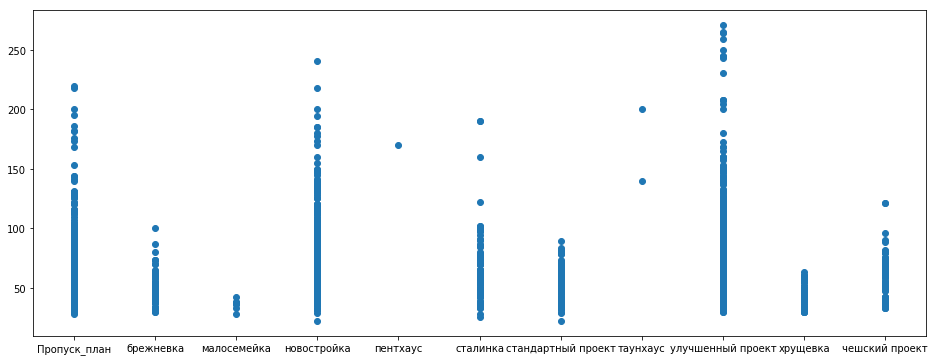

In [32]:
plt.scatter(flat_realt['Планировка'], flat_realt['total_area'])

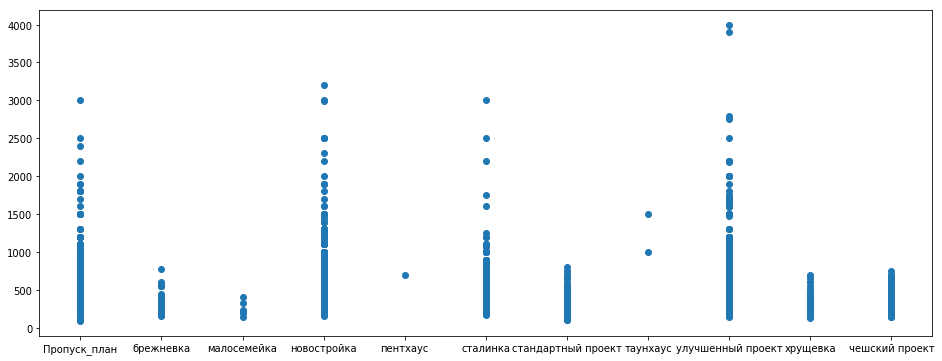

In [33]:
plt.scatter(flat_realt['Планировка'], flat_realt['price_usa'])

In [35]:
plan_union = {'брежневка':'standard_plan',
              'стандартный проект':'standard_plan',
              'хрущевка':'standard_plan',
              'чешский проект':'standard_plan',
              'сталинка':'сталинка',
              'новостройка': 'excellent_plan',
              'улучшенный проект':'excellent_plan',
              'таунхаус':'excellent_plan',
              'пентхаус':'excellent_plan',
              'малосемейка': 'standard_plan',
              'Пропуск_план':'Пропуск_план',
              }
flat_realt['plan_proc']=flat_realt['Планировка'].map(plan_union)

C:\Users\Aleh_Darashenka\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


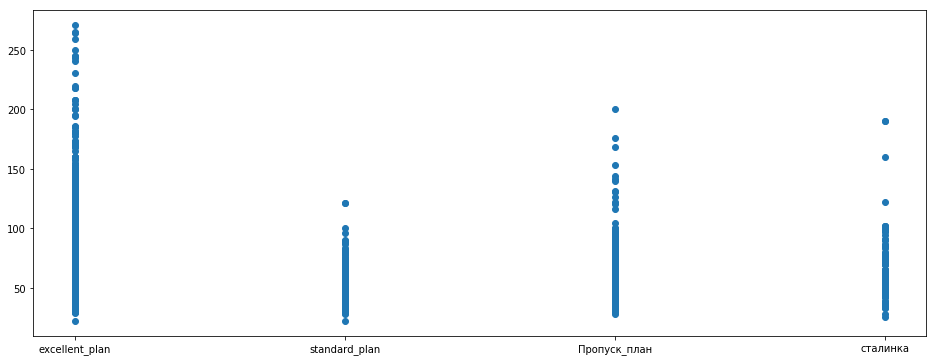

In [48]:
plt.scatter(flat_realt['plan_proc'], flat_realt['total_area'])

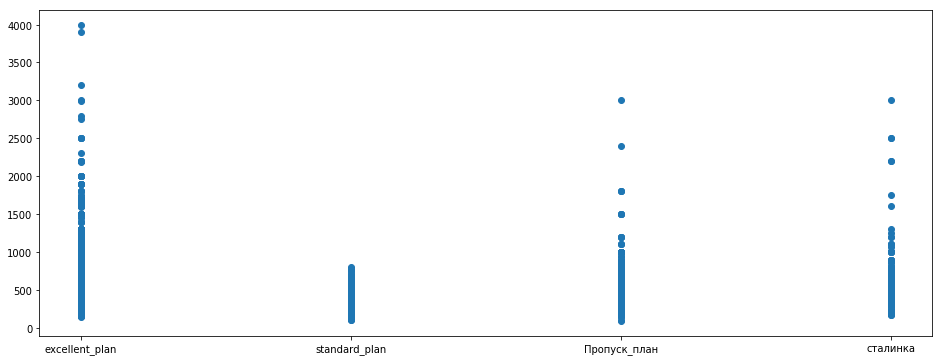

In [60]:
plt.scatter(flat_realt['plan_proc'], flat_realt['price_usa'])

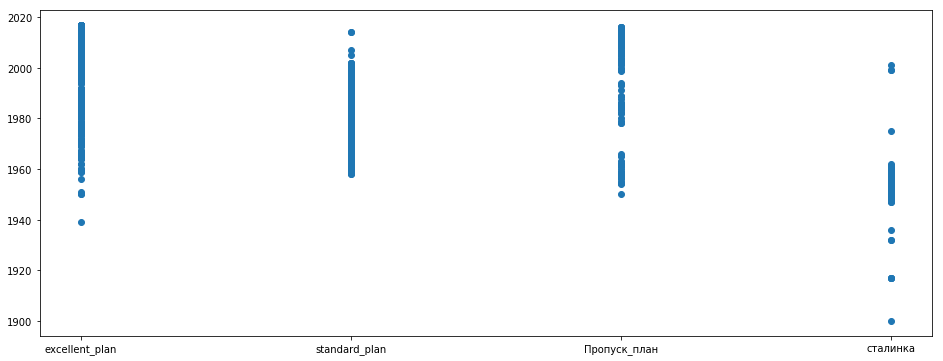

In [59]:
plt.scatter(flat_realt['plan_proc'], flat_realt['Год постройки'])

In [42]:
temp_val = flat_realt[(flat_realt['total_area']>100) & 
                      (flat_realt['plan_proc']=='Пропуск_план')] ['Год постройки']
temp_val2 = flat_realt[(flat_realt['plan_proc']=='Пропуск_план') & (flat_realt['price_usa']>1000)]['Год постройки']
def plan_rule(x):
    if x<1960:
        return 'сталинка'
    elif x>1990:
        return 'excellent_plan'
    else:
        return 'Пропуск_план'

flat_realt.loc[temp_val.index, 'plan_proc'] = temp_val.apply(lambda x: plan_rule(x))
flat_realt.loc[temp_val2.index, 'plan_proc'] = temp_val2.apply(lambda x: plan_rule(x))

C:\Users\Aleh_Darashenka\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [58]:
stalinka_flat = flat_realt[(flat_realt['plan_proc']=='Пропуск_план') & (flat_realt['Год постройки']<1950)]
flat_realt.loc[stalinka_flat.index, 'plan_proc'] = 'сталинка'

C:\Users\Aleh_Darashenka\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [61]:
flat_realt.groupby('plan_proc')['plan_proc'].count()

plan_proc
excellent_plan    1006
standard_plan      494
Пропуск_план       309
сталинка           135
Name: plan_proc, dtype: int64

In [87]:
#Нужно доработать
flat_realt['Год постройки'] = flat_realt['Год постройки'].fillna(value=
                                                                 flat_realt['Планировка'].apply(
                                                                     lambda x:flat_realt[flat_realt['Планировка']==x].groupby(
                                                                         by='Планировка')['Год постройки'].median().values[0] ))

C:\Users\Aleh_Darashenka\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Тип дома

In [71]:
flat_realt['Тип дома'].unique()

array(['кирпичный', 'панельный', 'Пропуск_тип', 'каркасно-блочный',
       'монолитный', 'монолитно-каркасный', 'блок-комнаты'], dtype=object)

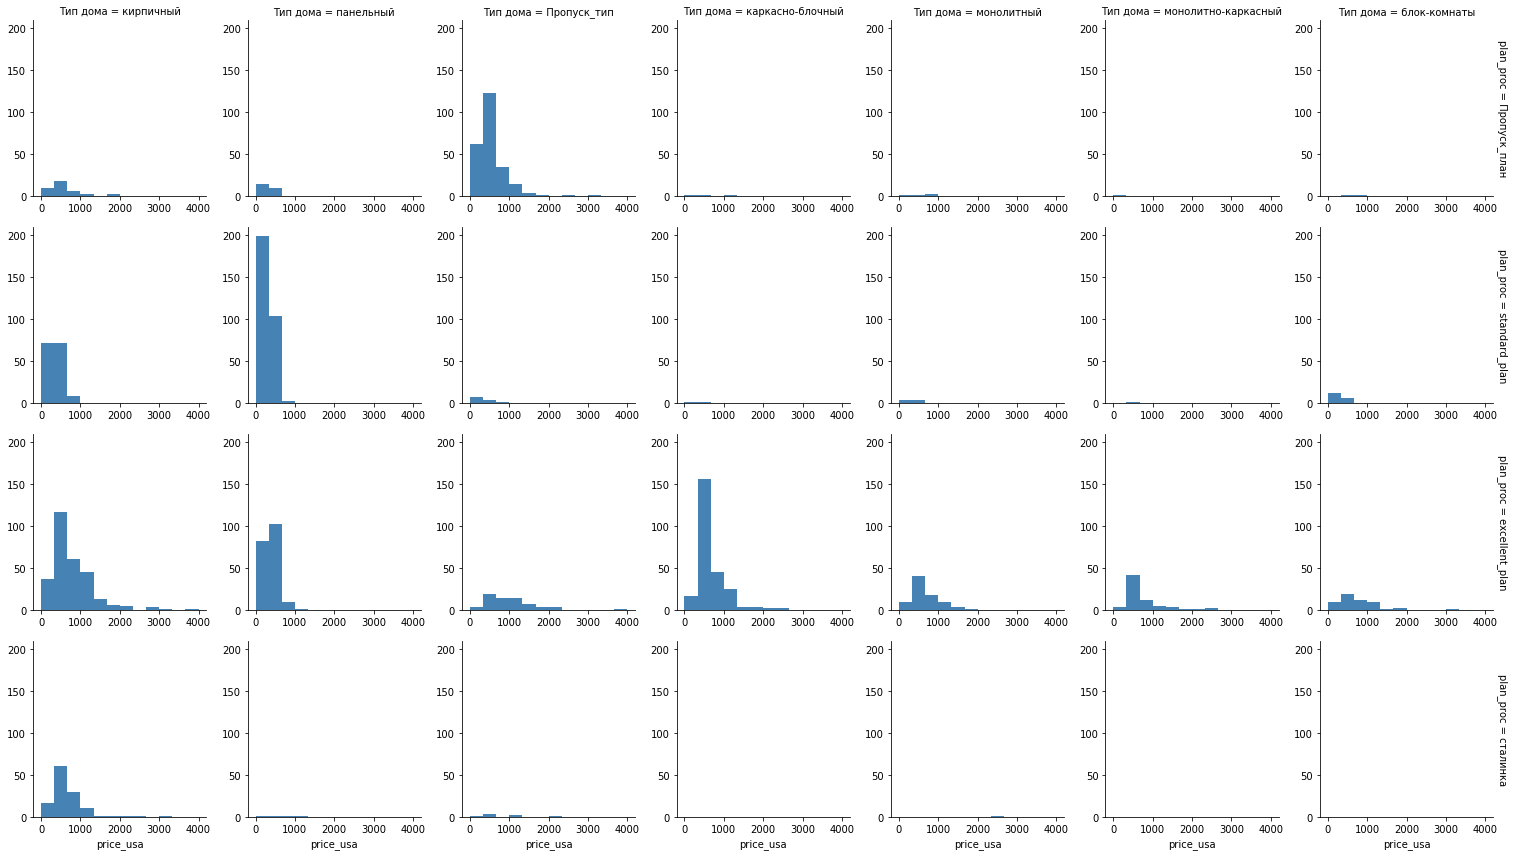

In [91]:

g = sns.FacetGrid(flat_realt, row="plan_proc",col='Тип дома', margin_titles=True)
bins = np.linspace(0, 4000, 13)
g.map(plt.hist, "price_usa", color="steelblue", bins=bins, lw=0)

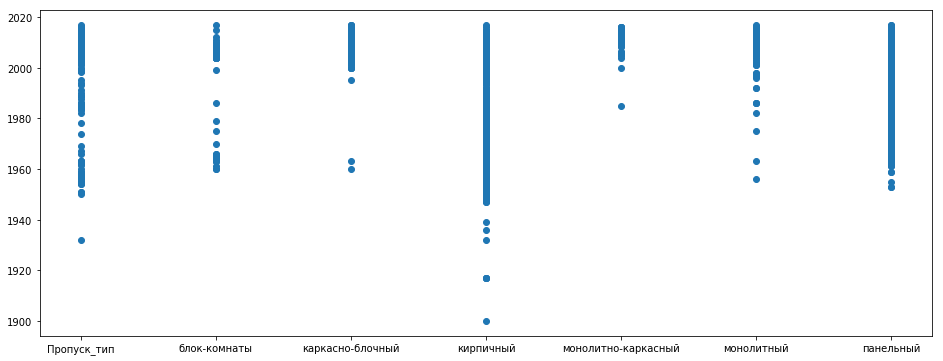

In [79]:
plt.scatter(flat_realt['Тип дома'], flat_realt['Год постройки'])

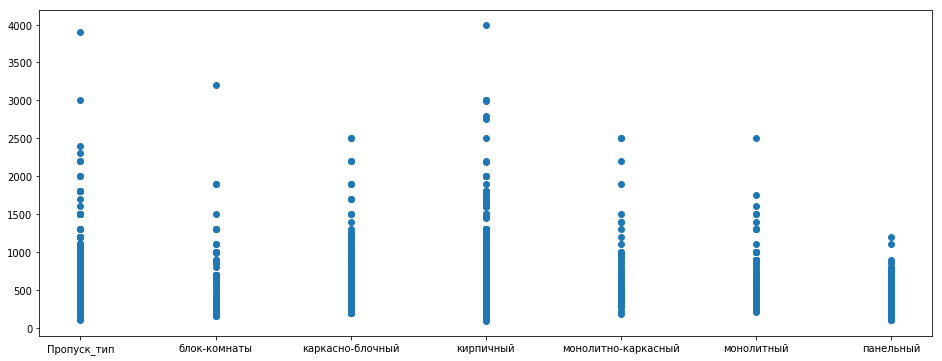

In [80]:
plt.scatter(flat_realt['Тип дома'], flat_realt['price_usa'])

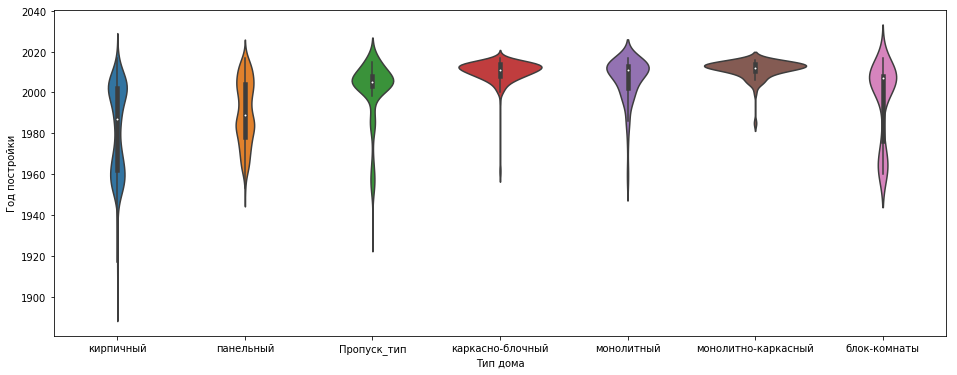

In [86]:
sns.violinplot(flat_realt['Тип дома'], flat_realt['Год постройки'])

#### Модель

In [66]:
def evaluate_model(reg, data, features, cv=5, transform_method=None, is_full=None):
    if is_full:
        dum_districts = pd.get_dummies(data['Район города'])
        dum_zones = pd.get_dummies(data['zones'])
        dum_plan = pd.get_dummies(data['plan_proc'])
        dum_type = pd.get_dummies(data['Тип дома'])
        data = pd.concat([data, dum_zones, dum_plan, dum_districts, dum_type], axis=1)
        features = features +\
        dum_districts.columns.values.tolist()+\
        dum_zones.columns.values.tolist() +\
        dum_type.columns.values.tolist() +\
        dum_plan.columns.values.tolist() 
    #transform data
    
    if transform_method:
        data = pd.DataFrame(transform_method.fit_transform(data[(features+['price_local','price_usa'])]), columns=features+['price_local','price_usa'])
    X_train, X_test, y_train, y_test = train_test_split(data[features], data['price_usa'], test_size=0.33, random_state=42)
    
    reg.fit(X_train, y_train)

    print("Mean Absolute Error: {:.8f}".format(mean_absolute_error(y_test, reg.predict(X_test))))
    print("Mean Squared Error: {:.8f}".format(mean_squared_error(y_test, reg.predict(X_test))))
    print("R2 score: {:.8f}".format(r2_score(y_test, reg.predict(X_test))))
    
    plt.plot(sorted(y_test), c='r')
    #plt.plot(sorted(y_test)+np.std(y_test))
    #plt.plot(sorted(y_test)-np.std(y_test))
    plt.scatter(range(len(y_test)), reg.predict(X_test.loc[y_test.sort_values().index.values]), s=1.7)
    plt.xlabel('sorted index')
    plt.ylabel('price usa')
    plt.grid()
    
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring='neg_mean_absolute_error', cv=cv)
    print(cross_scores)
    print("\nMean (MAE) CV {}-fold: {:.8f}".format(cv, -np.mean(cross_scores)))
    print("std (MAE) CV {}-fold: {:.8f}".format(cv, np.std(cross_scores)))
    return reg, features, data

In [67]:
features = [#'latitude',
            #longitude',
            'Балкон',
            'Мебель',
            'rooms',
            'total_area',
            'living_area',
            'kitchen_area',
            'Телефон',
            'Плита',
            'Ремонт',
            'floor',
            'floors',
            'Агентство',
            #'photos',
            'До центра',
            'До метро',
            #'views_week',
            'Сан/узел',
            'Год постройки',
            'photos_proc',
            'photo_exist',
            #'plan_proc'
           ]

Mean Absolute Error: 0.35471491
Mean Squared Error: 0.26061948
R2 score: 0.69054154
[-0.25558106 -0.28437184 -0.38584266 -0.36138001 -0.70449615]

Mean (MAE) CV 5-fold: 0.39833434
std (MAE) CV 5-fold: 0.16038869


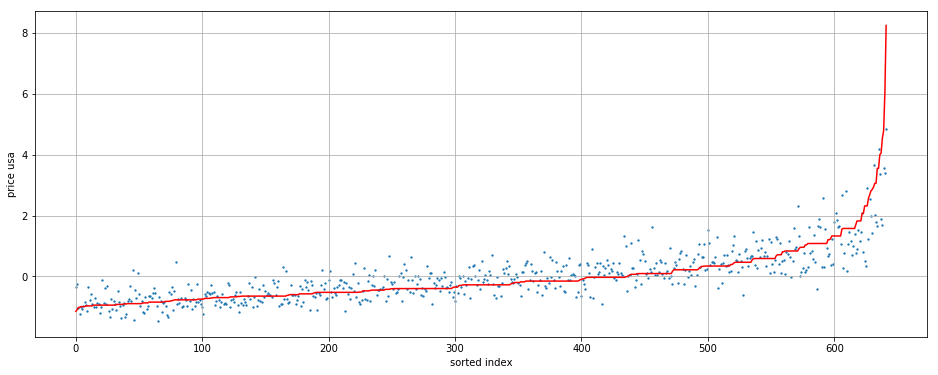

In [69]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
model10, feat_photo, data_photo = evaluate_model(Ridge(),flat_realt, features,  transform_method=StandardScaler(), is_full=True)

In [70]:
from eli5 import explain_weights
explain_weights(model10, feature_names = feat_photo, top=50)

Weight?,Feature
+0.690,total_area
+0.131,photos_proc
+0.098,"Независимости, Немига, Романовская слобода"
+0.083,Сан/узел
+0.076,Центральный район
+0.073,Год постройки
+0.062,Дрозды
+0.061,Медвежино
+0.050,"Маркса, Кирова"
+0.047,Мебель
